# w266 Final Project Notebook: BERT Model - Akhila Ganti

**Description:** We are going to explore Personal Health Mention multi classification using BERT and tune it to improve the model scores.

<a id = 'returnToTop'></a>

## Notebook Contents
  * 1. [Setup](#setup)
  * 2. [Data Acquisition](#dataAcquisition)
    * 2.0 [Data for BERT models](#model0)
    * 2.1 [Data for basic BERT model](#model1)    
    * 2.2 [Data for bio clinical BERT model](#model2)
    * 2.3 [Data for another clinical BERT model](#model3)
    * 2.4 [KFold CV data for BERT model](#model4)
  * 3. [Build BERT model](#bertBasics)
  * 4. [Text Classification with basic BERT model ](#BERTClassification)
  * 5. [Text Classification with Bio Clinical BERT model - freeze layers](#text1)
  * 6. [Text Classification with Bio Clinical BERT model - unfreeze layers](#text2)
  * 7. [Text Classification with another Clinical BERT model - unfreeze layers](#text3)
  * 8. [Text Classification with Bio Clinical BERT model - larger learning rate](#text4)
  * 9. [Text Classification with Bio Clinical BERT model - larger batch size](#text5)
  * 10. [Plots to compare BERT models](#Plots)
  * 11. [Bio Clinical BERT model using KFold CV](#KFold)


[Return to Top](#returnToTop)  
<a id = 'setup'></a>

## 1. Setup

This notebook requires the tensorflow dataset and other prerequisites that I download as part of the initial setup.

In [198]:
!pip install tensorflow-datasets --quiet

pydot is also helpful, along with **graphviz**.

In [199]:
!pip install pydot --quiet

For BERT and other Transformer libraries use Huggingface's implementations:

In [200]:
!pip install transformers --quiet

In [201]:
!pip install simpletransformers

Ready to do the imports.

In [202]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from transformers import BertTokenizer, TFBertModel, TFBertForSequenceClassification
from transformers import AutoTokenizer, AutoModel
from simpletransformers.classification import ClassificationModel
from transformers import logging
logging.set_verbosity_error()

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.datasets import load_digits
import sklearn as sk
import os
import nltk
from nltk.data import find

import matplotlib.pyplot as plt
import re
import seaborn as sns

[Return to Top](#returnToTop)  
<a id = 'dataAcquisition'></a>

## 2. Data Acquisition

We will use the X data, and split into training and test sets. For expedience, we will limit ourselves in terms of train and test examples.

2-0. Building data for BERT Models


In [203]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [204]:
#load data into pandas
df = pd.read_csv('/content/drive/MyDrive/hmc_tweets_266.csv')
df.head(10)

,Unnamed: 0,index,tweet_id,health_word,rating,rating_category,text
0,0,0,8.117468e+17,alzheimer,1,generic_health,New Alzheimer Society resources to support a m...
1,1,1,8.132130e+17,alzheimer,1,generic_health,What to Know About Thyroid and Alzheimer's htt...
2,2,2,8.117734e+17,alzheimer,1,generic_health,Hippocampus ! If this part are damage we could...
3,3,3,9.026493e+17,alzheimer,1,generic_health,How tackling hearing loss could reduce your ri...
4,4,4,9.055107e+17,alzheimer,1,generic_health,Finding the fun in the fog of Alzheimer’s\nvia...
5,5,5,9.026837e+17,alzheimer,1,generic_health,Encouraging!!! Study reveals what causes Alzh...
6,6,6,9.026787e+17,alzheimer,1,generic_health,A family of 6 drowned in a van. \n\n2 adults (...
7,7,7,9.026899e+17,alzheimer,1,generic_health,Stages of Alzheimer’s Disease and What to Expe...
8,8,8,8.131721e+17,alzheimer,1,generic_health,Taking statins for 6 months reduces risk of Al...
9,9,9,8.117440e+17,alzheimer,1,generic_health,The Telegraph will give £1 to Alzheimer's Rese...


In [205]:
df.tail(10)

,Unnamed: 0,index,tweet_id,health_word,rating,rating_category,text
9723,9723,9726,1.153124e+18,cancer,1,generic_health,Preventing excess body weight and obesity redu...
9724,9724,9727,1.153734e+18,parkinson,1,generic_health,That's a big hit! @nicholas_47 slog sweeps Par...
9725,9725,9728,1.153492e+18,cancer,1,generic_health,"until next year, Cancer season ✌🏼 https://t.co..."
9726,9726,9729,1.154117e+18,stroke,1,generic_health,Life is tough rn really need a stroke of good ...
9727,9727,9730,1.154456e+18,alzheimer,1,generic_health,Integrating Gene and Protein Expression Reveal...
9728,9728,9731,1.153613e+18,stroke,1,generic_health,Master stroke by @ImranKhanPTI ….. by taking r...
9729,9729,9732,1.154084e+18,cancer,1,generic_health,Breast implant maker Allergan Inc. issued a wo...
9730,9730,9733,1.154963e+18,alzheimer,1,generic_health,Lead (Pb) in Alzheimer's Dementia: A Systemati...
9731,9731,9734,1.154483e+18,alzheimer,1,generic_health,Carter Healthcare co-sponsored today's Walk to...
9732,9732,9735,1.154697e+18,alzheimer,1,generic_health,Massive congratulations to our cyclists who co...


In [206]:
texts = [text.lower() for text in df.text]

In [207]:
len(texts)

9733

In [208]:
len(df.rating)

9733

In [209]:
df.rating_category

0       generic_health
1       generic_health
2       generic_health
3       generic_health
4       generic_health
             ...      
9728    generic_health
9729    generic_health
9730    generic_health
9731    generic_health
9732    generic_health
Name: rating_category, Length: 9733, dtype: object

In [210]:
labels = df.rating

In [211]:
label_names = df.rating_category


In [212]:
target_names = label_names.unique()
target_names

array(['generic_health', 'personal_health', 'figurative'], dtype=object)

In [213]:
len(labels)

9733

In [214]:
labels.shape

(9733,)

In [215]:
# One-hot encode the 'rating' column
#encoded_labels = pd.get_dummies(df['rating']).values
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)


In [216]:
X_train[:5]

['i take back what i said about fever 333 a few days ago, they are the modern day rage against the machine.',
 'depression on top of other mental illness really hit different lmao',
 "my niume creative writing challenge for out-thinking parkinson's  https://t.co/5ve07xhwas #asmsg",
 'hot and humid weather &amp; exposure to sun in hot &amp; humid weather can cause migraine. best is relax &amp; avoid tweeter 😊 https://t.co/soly6svnix',
 'researchers combined measurements of drawing speed and pen pressure to diagnose #parkinson’s disease severity. https://t.co/b4k15f3ff1 https://t.co/ejmrzjichv']

In [217]:
y_train[:5]

8029    1
8811    2
1918    1
8022    1
2029    1
Name: rating, dtype: int64

In [218]:
X_test[:5]

['breast cancer signs, symptoms and treatment - https://t.co/2xzfnifvya https://t.co/wsmuz6nsyd',
 'every time i cough augie wakes up, rolls over, and huffs as loud as he possibly can.....because naturally i got this sinus cold on purpose just to inconvenience his sleep.',
 'this headache kicking my ass 😩',
 "i've #justsponsored richard caborn, who's fundraising for alzheimer's society on @justgiving. donate now https://t.co/ocsfnt5tap",
 'every person ever: "you have cancer? my cousin\'s husband\'s mom just died of cancer!"\nthanks janet, that\'s really encouraging.\n\n#cancerprobs']

In [219]:
y_test[:5]

2884    1
7451    2
7653    2
637     1
2310    2
Name: rating, dtype: int64

In [274]:
y_test_np = y_test.to_numpy()

In [275]:
y_test_np[:5]

array([1, 2, 2, 1, 2])

2-1. Building data for BERT Model1

In [220]:
# Load pre-trained BERT model
checkpoint = 'bert-base-cased'
bert_tokenizer = BertTokenizer.from_pretrained(checkpoint)
bert_model = TFBertForSequenceClassification.from_pretrained(checkpoint)

In [221]:
bert_train_input = bert_tokenizer(X_train,
              max_length=128,
              truncation=True,
              padding='max_length',
              return_tensors='tf')

bert_train_input

{'input_ids': <tf.Tensor: shape=(7786, 128), dtype=int32, numpy=
array([[  101,   178,  1321, ...,     0,     0,     0],
       [  101,  7560,  1113, ...,     0,     0,     0],
       [  101,  1139, 11437, ...,     0,     0,     0],
       ...,
       [  101,   192,  1204, ...,     0,     0,     0],
       [  101,  6479,  1437, ...,     0,     0,     0],
       [  101,  1142,  1940, ...,     0,     0,     0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(7786, 128), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(7786, 128), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=in

In [222]:
bert_test_input = bert_tokenizer(X_test,
              max_length=128,
              truncation=True,
              padding='max_length',
              return_tensors='tf')

bert_test_input

{'input_ids': <tf.Tensor: shape=(1947, 128), dtype=int32, numpy=
array([[  101,  7209,  4182, ...,     0,     0,     0],
       [  101,  1451,  1159, ...,     0,     0,     0],
       [  101,  1142, 16320, ...,     0,     0,     0],
       ...,
       [  101,  1165,  1128, ...,     0,     0,     0],
       [  101,  2731,  7508, ...,     0,     0,     0],
       [  101,  3306,   170, ...,     0,     0,     0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1947, 128), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1947, 128), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=in

2-2. Data for Bio Clinical BERT Model2

In [226]:
biobert_tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
biobert_model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

In [227]:
biobert_train_input = biobert_tokenizer(X_train,
              max_length=128,
              truncation=True,
              padding='max_length',
              return_tensors='tf')

biobert_train_input

{'input_ids': <tf.Tensor: shape=(7786, 128), dtype=int32, numpy=
array([[  101,   178,  1321, ...,     0,     0,     0],
       [  101,  7560,  1113, ...,     0,     0,     0],
       [  101,  1139, 11437, ...,     0,     0,     0],
       ...,
       [  101,   192,  1204, ...,     0,     0,     0],
       [  101,  6479,  1437, ...,     0,     0,     0],
       [  101,  1142,  1940, ...,     0,     0,     0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(7786, 128), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(7786, 128), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=in

In [228]:
biobert_test_input = biobert_tokenizer(X_test,
              max_length=128,
              truncation=True,
              padding='max_length',
              return_tensors='tf')

biobert_test_input

{'input_ids': <tf.Tensor: shape=(1947, 128), dtype=int32, numpy=
array([[  101,  7209,  4182, ...,     0,     0,     0],
       [  101,  1451,  1159, ...,     0,     0,     0],
       [  101,  1142, 16320, ...,     0,     0,     0],
       ...,
       [  101,  1165,  1128, ...,     0,     0,     0],
       [  101,  2731,  7508, ...,     0,     0,     0],
       [  101,  3306,   170, ...,     0,     0,     0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1947, 128), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1947, 128), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=in

2-3. Data for Clinical BERT Model3

In [229]:
clinicalbert_tokenizer = AutoTokenizer.from_pretrained("DATEXIS/CORe-clinical-diagnosis-prediction")
clinicalbert_model = AutoModel.from_pretrained("DATEXIS/CORe-clinical-diagnosis-prediction")


In [230]:
clinicalbert_train_input = clinicalbert_tokenizer(X_train,
              max_length=128,
              truncation=True,
              padding='max_length',
              return_tensors='tf')

clinicalbert_train_input

{'input_ids': <tf.Tensor: shape=(7786, 128), dtype=int32, numpy=
array([[  101,   178,  1321, ...,     0,     0,     0],
       [  101,  7560,  1113, ...,     0,     0,     0],
       [  101,  1139, 11437, ...,     0,     0,     0],
       ...,
       [  101,   192,  1204, ...,     0,     0,     0],
       [  101,  6479,  1437, ...,     0,     0,     0],
       [  101,  1142,  1940, ...,     0,     0,     0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(7786, 128), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(7786, 128), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=in

In [231]:
clinicalbert_test_input = clinicalbert_tokenizer(X_test,
              max_length=128,
              truncation=True,
              padding='max_length',
              return_tensors='tf')

clinicalbert_test_input

{'input_ids': <tf.Tensor: shape=(1947, 128), dtype=int32, numpy=
array([[  101,  7209,  4182, ...,     0,     0,     0],
       [  101,  1451,  1159, ...,     0,     0,     0],
       [  101,  1142, 16320, ...,     0,     0,     0],
       ...,
       [  101,  1165,  1128, ...,     0,     0,     0],
       [  101,  2731,  7508, ...,     0,     0,     0],
       [  101,  3306,   170, ...,     0,     0,     0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1947, 128), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1947, 128), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=in

2-4. Building data for BERT Model5

using KFold cross validation

In [232]:
text_n_rating = [[texts, labels] for texts, labels in zip(texts, labels)]

In [233]:
X3_data = pd.DataFrame(text_n_rating)

In [234]:
X3_data.shape

(9733, 2)

In [235]:
X3_data[:-5]

,0,1
0,new alzheimer society resources to support a m...,1
1,what to know about thyroid and alzheimer's htt...,1
2,hippocampus ! if this part are damage we could...,1
3,how tackling hearing loss could reduce your ri...,1
4,finding the fun in the fog of alzheimer’s\nvia...,1
...,...,...
9723,preventing excess body weight and obesity redu...,1
9724,that's a big hit! @nicholas_47 slog sweeps par...,1
9725,"until next year, cancer season ✌🏼 https://t.co...",1
9726,life is tough rn really need a stroke of good ...,1


[Return to Top](#returnToTop)  
<a id = '3. Build BERT model(using the Pooler Output)'></a>
# 3. Build BERT model (using the Pooler Output)

In [236]:
MAX_SEQUENCE_LENGTH = 128

In [237]:
def create_bert_classification_model(bert_model,
                                     num_classes = 3,
                                     hidden_size = 128,
                                     dropout=0.3,
                                     learning_rate=0.00005,
                                     num_train_layers = 0):
    """
    Build a simple classification model with BERT. Use the Pooler Output for classification purposes
    """
    # Load pre-trained BERT model
    bert_model = TFBertModel.from_pretrained(checkpoint)

    if num_train_layers == 1:
        # unfreeze all layers of pre-trained BERT model to update pre-trained weights
        bert_model.trainable = True
    else:
        # Freeze all layers of the BERT model to keep the pre-trained weights
        bert_model.trainable = False

    input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = bert_model(bert_inputs)

    pooler_token = bert_out[1]

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(pooler_token)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)


    classification = tf.keras.layers.Dense(3, activation='softmax',name='classification_layer')(hidden)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.sparse_categorical_crossentropy,
                                 metrics='accuracy')

    return classification_model

[Return to Top](#returnToTop)  
<a id = '4. Text Classification with BERT model'></a>
# 4. Text Classification with BERT model

In [238]:
#get a fresh instance of the bert_model
bert_model = TFBertModel.from_pretrained(checkpoint)
bert_classification_model1 = create_bert_classification_model(bert_model, num_classes=3)

In [239]:
#confirm all layers are frozen
bert_classification_model1.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 128)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 128)]                0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids_layer (Inpu  [(None, 128)]                0         []                            
 tLayer)                                                                                    

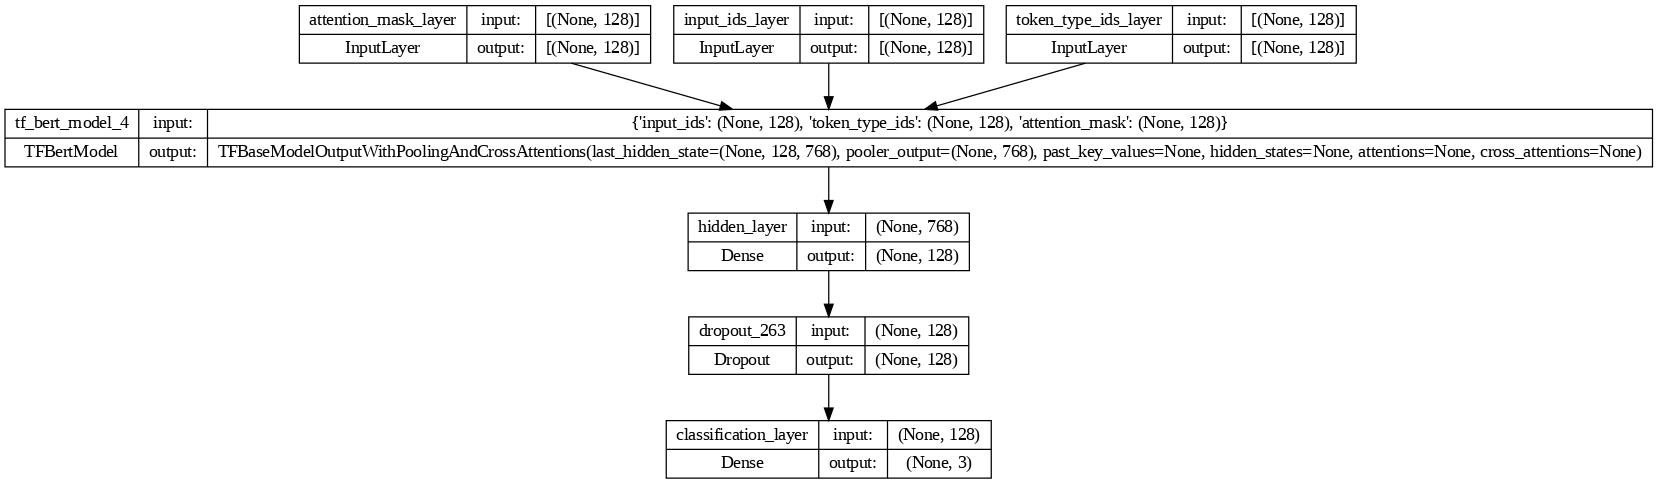

In [240]:
keras.utils.plot_model(bert_classification_model1, show_shapes=True, dpi=90)

In [241]:
bert_classification_model1_history = bert_classification_model1.fit(
    [bert_train_input.input_ids, bert_train_input.token_type_ids, bert_train_input.attention_mask],
    y_train,
    validation_data=([bert_test_input.input_ids, bert_test_input.token_type_ids, bert_test_input.attention_mask], y_test),
    batch_size=8,
    epochs=5
)

Epoch 1/5
974/974 [==============================] - 80s 67ms/step - loss: 1.0610 - accuracy: 0.4448 - val_loss: 0.9622 - val_accuracy: 0.5367
Epoch 2/5
974/974 [==============================] - 72s 74ms/step - loss: 0.9560 - accuracy: 0.5338 - val_loss: 0.9145 - val_accuracy: 0.5696
Epoch 3/5
974/974 [==============================] - 71s 73ms/step - loss: 0.9287 - accuracy: 0.5591 - val_loss: 0.9039 - val_accuracy: 0.5881
Epoch 4/5
974/974 [==============================] - 72s 74ms/step - loss: 0.9097 - accuracy: 0.5647 - val_loss: 0.8857 - val_accuracy: 0.6061
Epoch 5/5
974/974 [==============================] - 61s 62ms/step - loss: 0.8966 - accuracy: 0.5741 - val_loss: 0.8886 - val_accuracy: 0.6143


In [242]:
# #eval b=8 e=1 dim=201
score = bert_classification_model1.evaluate([bert_test_input.input_ids, bert_test_input.token_type_ids, bert_test_input.attention_mask],
                                                  y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

61/61 [==============================] - 9s 139ms/step - loss: 0.8886 - accuracy: 0.6143
Test loss: 0.888568103313446
Test accuracy: 0.6142783761024475


In [243]:
#run predict for the first three elements in the test data set
predictions = bert_classification_model1.predict([bert_test_input.input_ids[:3], bert_test_input.token_type_ids[:3], bert_test_input.attention_mask[:3]])

1/1 [==============================] - 6s 6s/step


In [244]:
#run and capture all predictions from our test set using model.predict
predictions_model1 = bert_classification_model1.predict([bert_test_input.input_ids, bert_test_input.token_type_ids, bert_test_input.attention_mask])

#now we need to get the highest probability in the distribution for each prediction
#and store that in a tf.Tensor
predictions_model1 = tf.argmax(predictions_model1, axis=-1)
predictions_model1

61/61 [==============================] - 6s 102ms/step


<tf.Tensor: shape=(1947,), dtype=int64, numpy=array([1, 2, 2, ..., 2, 1, 0])>

In [245]:
print(classification_report(y_test, predictions_model1.numpy(), target_names=target_names))

                 precision    recall  f1-score   support

 generic_health       0.54      0.57      0.56       688
personal_health       0.76      0.68      0.72       676
     figurative       0.56      0.59      0.57       583

       accuracy                           0.61      1947
      macro avg       0.62      0.61      0.62      1947
   weighted avg       0.62      0.61      0.62      1947



In [246]:
print(confusion_matrix(y_test, predictions_model1))

[[393  85 210]
 [158 460  58]
 [176  64 343]]


In [247]:
predicted_labels = predictions_model1

In [248]:
cm = confusion_matrix(y_test, predictions_model1)

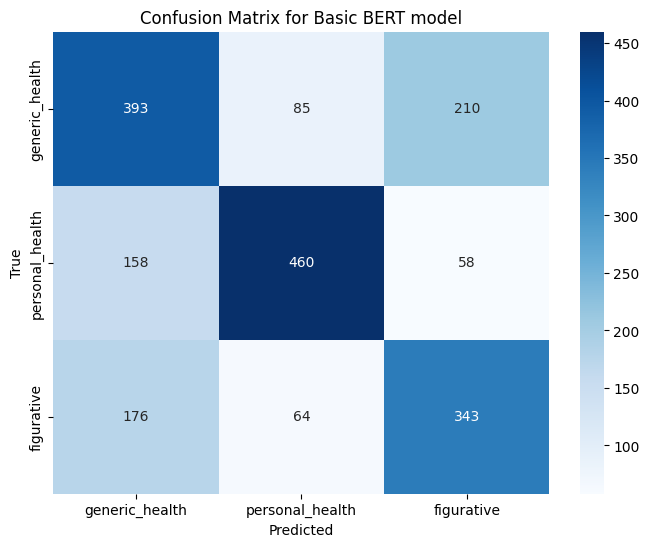

In [332]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['generic_health', 'personal_health', 'figurative'],
            yticklabels=['generic_health', 'personal_health', 'figurative'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Basic BERT model')
plt.show()

[Return to Top](#returnToTop)  
<a id = '5. Text Classification with Bio Clinical BERT model '></a>
# 5. Text Classification with Bio Clinical BERT model

Build Bio Clinical BERT Model2

In [ ]:
#get a fresh instance of the Bio_ClinicalBERT_model
biobert_model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
biobert_classification_model2 = create_bert_classification_model(biobert_model, num_classes=3)

biobert_classification_model2_history = biobert_classification_model2.fit(
    [biobert_train_input.input_ids, biobert_train_input.token_type_ids, biobert_train_input.attention_mask],
    y_train,
    validation_data=([biobert_test_input.input_ids, biobert_test_input.token_type_ids, biobert_test_input.attention_mask], y_test),
    batch_size=8,
    epochs=5
)


Epoch 1/5
974/974 [==============================] - 128s 117ms/step - loss: 1.0597 - accuracy: 0.4526 - val_loss: 0.9541 - val_accuracy: 0.5629
Epoch 2/5
974/974 [==============================] - 110s 113ms/step - loss: 0.9566 - accuracy: 0.5369 - val_loss: 0.9191 - val_accuracy: 0.5670
Epoch 3/5
974/974 [==============================] - 111s 114ms/step - loss: 0.9264 - accuracy: 0.5568 - val_loss: 0.8983 - val_accuracy: 0.5881
Epoch 4/5
974/974 [==============================] - 111s 114ms/step - loss: 0.9157 - accuracy: 0.5638 - val_loss: 0.8980 - val_accuracy: 0.5681
Epoch 5/5
974/974 [==============================] - 110s 113ms/step - loss: 0.9031 - accuracy: 0.5717 - val_loss: 0.8806 - val_accuracy: 0.5958


In [ ]:
#confirm all layers are frozen
biobert_classification_model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 128)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 128)]                0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids_layer (Inpu  [(None, 128)]                0         []                            
 tLayer)                                                                                    

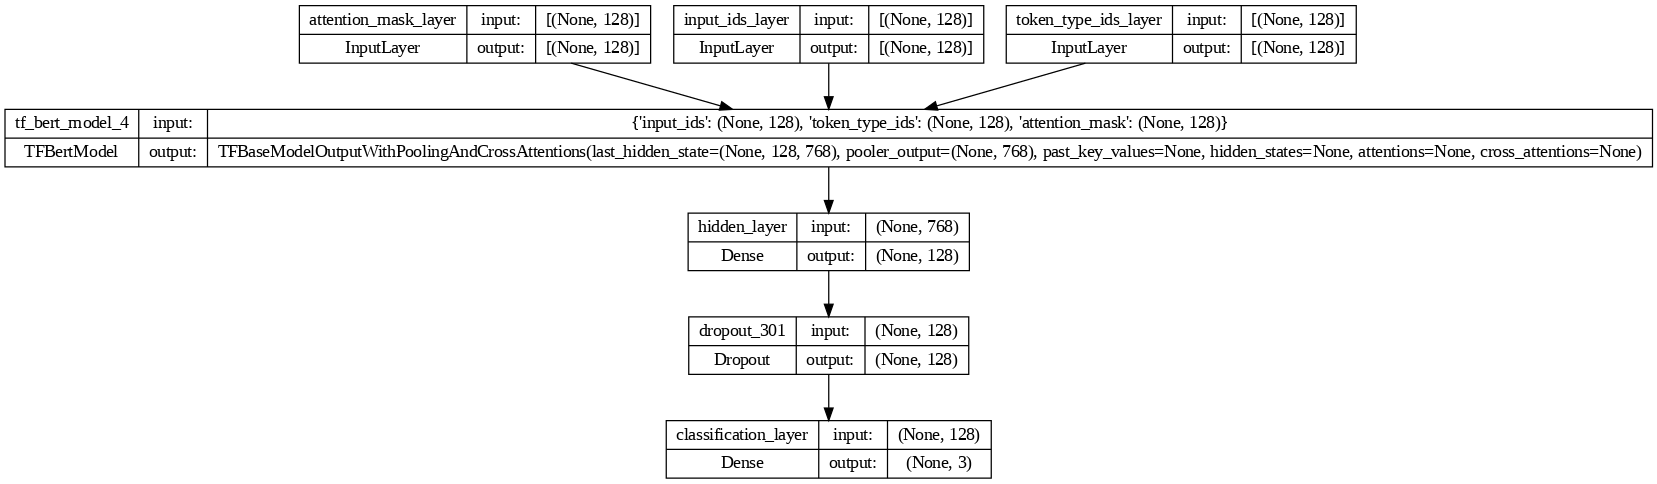

In [ ]:
keras.utils.plot_model(biobert_classification_model2, show_shapes=True, dpi=90)

In [ ]:
# #eval b=8 e=1 dim=128
score = biobert_classification_model2.evaluate([biobert_test_input.input_ids, biobert_test_input.token_type_ids, biobert_test_input.attention_mask],
                                                  y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

61/61 [==============================] - 17s 278ms/step - loss: 0.8806 - accuracy: 0.5958
Test loss: 0.8805518746376038
Test accuracy: 0.5957884192466736


In [ ]:
#run and capture all predictions from our test set using model.predict
predictions_model2 = biobert_classification_model2.predict([biobert_test_input.input_ids, biobert_test_input.token_type_ids, biobert_test_input.attention_mask])

#now we need to get the highest probability in the distribution for each prediction
#and store that in a tf.Tensor
predictions_model2 = tf.argmax(predictions_model2, axis=-1)
predictions_model2

61/61 [==============================] - 20s 281ms/step


<tf.Tensor: shape=(1947,), dtype=int64, numpy=array([1, 2, 0, ..., 0, 1, 0])>

In [ ]:
print(classification_report(y_test, predictions_model2.numpy(), target_names=target_names))

                 precision    recall  f1-score   support

 generic_health       0.51      0.66      0.58       688
personal_health       0.68      0.75      0.71       676
     figurative       0.64      0.34      0.45       583

       accuracy                           0.60      1947
      macro avg       0.61      0.58      0.58      1947
   weighted avg       0.61      0.60      0.58      1947



Build Bio Clinical BERT with unfrozen pre-trained layers and run 3 epochs **Model3a**

[Return to Top](#returnToTop)  
<a id = '6. Text Classification with Bio Clinical BERT - unfreeze layers '></a>
# 6. Text Classification with Bio Clinical BERT - unfreeze layers

In [307]:
#get a fresh instance of the first Bio_ClinicalBERT_model + unfreeze pre-trained layers
clinicalbert_model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
clinicalbert_classification_model3a = create_bert_classification_model(clinicalbert_model, num_classes=3, num_train_layers = 1)


In [308]:
#confirm all layers are unfrozen
clinicalbert_classification_model3a.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 128)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 128)]                0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids_layer (Inpu  [(None, 128)]                0         []                            
 tLayer)                                                                                    

In [309]:
clinicalbert_classification_model3a_history = clinicalbert_classification_model3a.fit(
    [biobert_train_input.input_ids, biobert_train_input.token_type_ids, biobert_train_input.attention_mask],
    y_train,
    validation_data=([biobert_test_input.input_ids, biobert_test_input.token_type_ids, biobert_test_input.attention_mask], y_test),
    batch_size=8,
    epochs=3
)

Epoch 1/3
974/974 [==============================] - 184s 142ms/step - loss: 0.5503 - accuracy: 0.7919 - val_loss: 0.3991 - val_accuracy: 0.8618
Epoch 2/3
974/974 [==============================] - 122s 125ms/step - loss: 0.2885 - accuracy: 0.9061 - val_loss: 0.4490 - val_accuracy: 0.8685
Epoch 3/3
974/974 [==============================] - 131s 134ms/step - loss: 0.1772 - accuracy: 0.9391 - val_loss: 0.4241 - val_accuracy: 0.8706


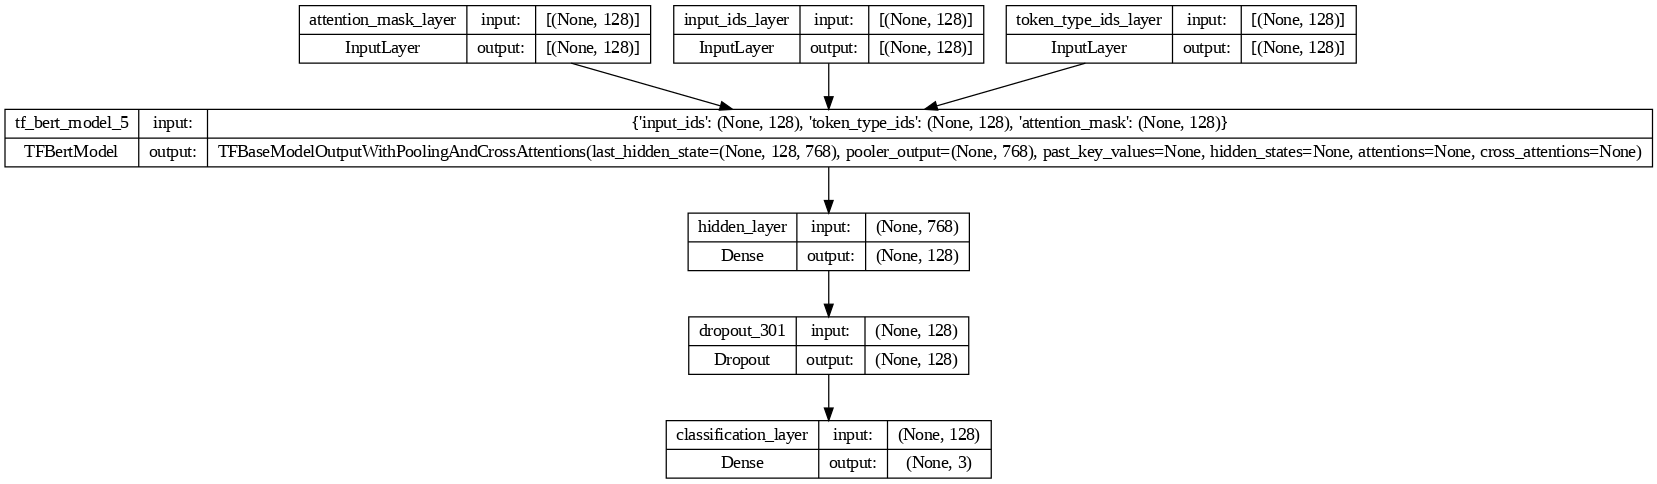

In [310]:
keras.utils.plot_model(clinicalbert_classification_model3a, show_shapes=True, dpi=90)

In [311]:
# #eval b=8 e=1 dim=201
score = clinicalbert_classification_model3a.evaluate([biobert_test_input.input_ids, biobert_test_input.token_type_ids, biobert_test_input.attention_mask],
                                                  y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

61/61 [==============================] - 7s 107ms/step - loss: 0.4241 - accuracy: 0.8706
Test loss: 0.42410948872566223
Test accuracy: 0.8705701231956482


In [312]:
#run and capture all predictions from our test set using model.predict
predictions_model3a = clinicalbert_classification_model3a.predict([biobert_test_input.input_ids, biobert_test_input.token_type_ids, biobert_test_input.attention_mask])

#now we need to get the highest probability in the distribution for each prediction
#and store that in a tf.Tensor
predictions_model3a = tf.argmax(predictions_model3a, axis=-1)
predictions_model3a

61/61 [==============================] - 10s 109ms/step


<tf.Tensor: shape=(1947,), dtype=int64, numpy=array([1, 2, 2, ..., 2, 1, 0])>

In [313]:
predictions_model3a.shape

TensorShape([1947])

In [314]:
y_pred = predictions_model3a.numpy()

In [315]:
y_pred

array([1, 2, 2, ..., 2, 1, 0])

In [316]:
print(classification_report(y_test, y_pred, target_names=target_names))

                 precision    recall  f1-score   support

 generic_health       0.89      0.86      0.87       688
personal_health       0.87      0.86      0.87       676
     figurative       0.85      0.89      0.87       583

       accuracy                           0.87      1947
      macro avg       0.87      0.87      0.87      1947
   weighted avg       0.87      0.87      0.87      1947



In [329]:
y_test[:5]

2884    1
7451    2
7653    2
637     1
2310    2
Name: rating, dtype: int64

In [318]:
y_test_np

array([1, 2, 2, ..., 1, 1, 0])

0

In [319]:
print(confusion_matrix(y_test_np, y_pred))

[[593  48  47]
 [ 49 582  45]
 [ 26  37 520]]


In [321]:
predicted_labels3 = predictions_model3a

In [322]:
cm3a = confusion_matrix(y_test_np, y_pred)

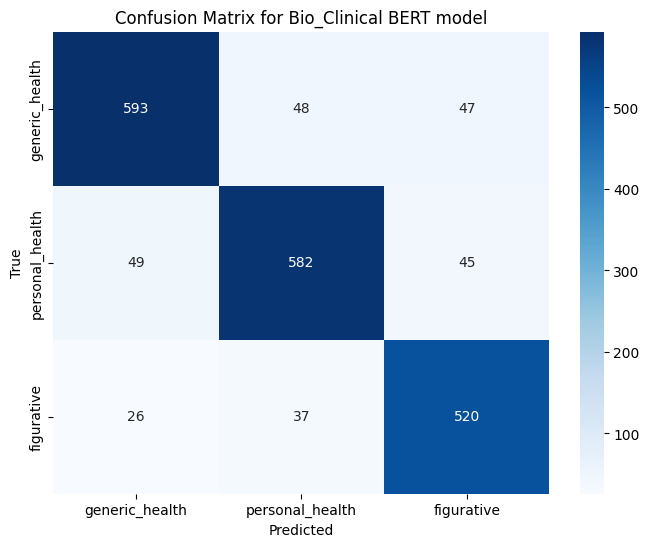

In [331]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm3a, annot=True, fmt='d', cmap='Blues',
            xticklabels=['generic_health', 'personal_health', 'figurative'],
            yticklabels=['generic_health', 'personal_health', 'figurative'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Bio_Clinical BERT model')
plt.show()

In [290]:
correct_predictions = y_pred == y_test_np

In [294]:
correct_predictions.shape

(1947,)

In [344]:
incorrect_predictions = y_pred != y_test_np

In [345]:
incorrect_predictions.shape

(1947,)

In [292]:
y_test_np[correct_predictions]

array([1, 2, 2, ..., 1, 1, 0])

In [293]:
y_test_np.shape

(1947,)

In [346]:
sum(tf.cast(correct_predictions, tf.int32))/1947

<tf.Tensor: shape=(), dtype=float64, numpy=0.8705701078582434>

In [347]:
sum(tf.cast(incorrect_predictions, tf.int32))/1947

<tf.Tensor: shape=(), dtype=float64, numpy=0.12942989214175654>

In [338]:
df_test = df[:1947]

In [340]:
correct_predictions = y_pred == y_test_np
incorrect_predictions = y_pred != y_test_np

df_test['correct'] = correct_predictions
df_test['incorrect'] = incorrect_predictions
df_test_result = df_test


<ipython-input-340-a52caa5f34f3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['correct'] = correct_predictions
<ipython-input-340-a52caa5f34f3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['incorrect'] = incorrect_predictions


In [342]:
df_test.shape

(1947, 9)

In [357]:
df_test[:25]

,Unnamed: 0,index,tweet_id,health_word,rating,rating_category,text,correct,incorrect
0,0,0,8.117468e+17,alzheimer,1,generic_health,New Alzheimer Society resources to support a m...,True,False
1,1,1,8.132130e+17,alzheimer,1,generic_health,What to Know About Thyroid and Alzheimer's htt...,True,False
2,2,2,8.117734e+17,alzheimer,1,generic_health,Hippocampus ! If this part are damage we could...,True,False
3,3,3,9.026493e+17,alzheimer,1,generic_health,How tackling hearing loss could reduce your ri...,True,False
4,4,4,9.055107e+17,alzheimer,1,generic_health,Finding the fun in the fog of Alzheimer’s\nvia...,True,False
5,5,5,9.026837e+17,alzheimer,1,generic_health,Encouraging!!! Study reveals what causes Alzh...,True,False
6,6,6,9.026787e+17,alzheimer,1,generic_health,A family of 6 drowned in a van. \n\n2 adults (...,False,True
7,7,7,9.026899e+17,alzheimer,1,generic_health,Stages of Alzheimer’s Disease and What to Expe...,False,True
8,8,8,8.131721e+17,alzheimer,1,generic_health,Taking statins for 6 months reduces risk of Al...,True,False
9,9,9,8.117440e+17,alzheimer,1,generic_health,The Telegraph will give £1 to Alzheimer's Rese...,True,False


In [351]:
df_test_result[7:8]

,Unnamed: 0,index,tweet_id,health_word,rating,rating_category,text,correct,incorrect
7,7,7,9.026899e+17,alzheimer,1,generic_health,Stages of Alzheimer’s Disease and What to Expe...,False,True


In [352]:
df_test_result[19:20]

,Unnamed: 0,index,tweet_id,health_word,rating,rating_category,text,correct,incorrect
19,19,19,8.132092e+17,alzheimer,2,personal_health,"@teddavid @Mediaite He had Alzheimer's, which ...",False,True


Build a different Clinical BERT with unfrozen pre-trained layers and run 3 epochs **Model3b**

[Return to Top](#returnToTop)  
<a id = '7. Text Classification with another Clinical BERT - unfreeze layers'></a>
# 7. Text Classification with another Clinical BERT - unfreeze layers

In [358]:
#get a fresh instance of the second ClinicalBERT_model + unfreeze pre-trained layers
clinicalbert_model = AutoModel.from_pretrained("DATEXIS/CORe-clinical-diagnosis-prediction")
clinicalbert_classification_model3b = create_bert_classification_model(clinicalbert_model, num_classes=3, num_train_layers = 1)


In [359]:
#confirm all layers are unfrozen
clinicalbert_classification_model3b.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 128)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 128)]                0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids_layer (Inpu  [(None, 128)]                0         []                            
 tLayer)                                                                                    

In [ ]:
clinicalbert_classification_model3b_history = clinicalbert_classification_model3b.fit(
    [clinicalbert_train_input.input_ids, clinicalbert_train_input.token_type_ids, clinicalbert_train_input.attention_mask],
    y_train,
    validation_data=([clinicalbert_test_input.input_ids, clinicalbert_test_input.token_type_ids, clinicalbert_test_input.attention_mask], y_test),
    batch_size=8,
    epochs=3
)

Epoch 1/3
974/974 [==============================] - 310s 269ms/step - loss: 0.5495 - accuracy: 0.7959 - val_loss: 0.3865 - val_accuracy: 0.8464
Epoch 2/3
974/974 [==============================] - 276s 284ms/step - loss: 0.2945 - accuracy: 0.9020 - val_loss: 0.4550 - val_accuracy: 0.8418
Epoch 3/3
974/974 [==============================] - 274s 282ms/step - loss: 0.1801 - accuracy: 0.9462 - val_loss: 0.4851 - val_accuracy: 0.8598


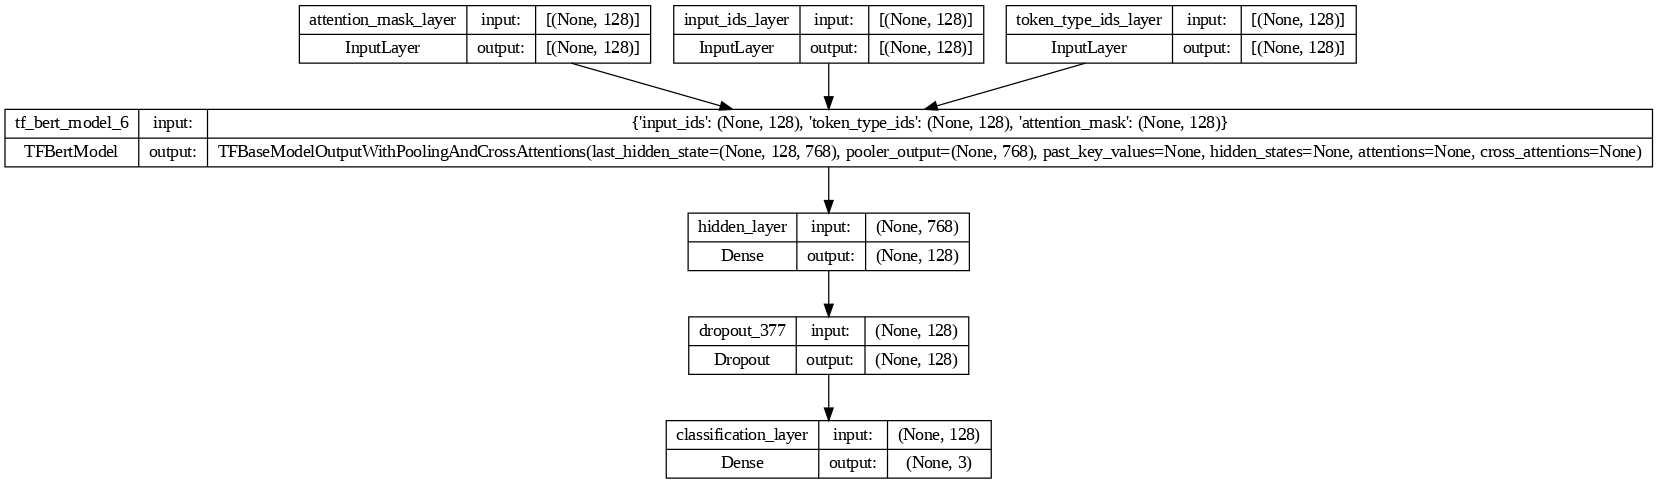

In [ ]:
keras.utils.plot_model(clinicalbert_classification_model3b, show_shapes=True, dpi=90)

In [ ]:
# #eval b=8 e=1 dim=201
score = clinicalbert_classification_model3b.evaluate([clinicalbert_test_input.input_ids, clinicalbert_test_input.token_type_ids, clinicalbert_test_input.attention_mask],
                                                  y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

61/61 [==============================] - 17s 280ms/step - loss: 0.4851 - accuracy: 0.8598
Test loss: 0.4850974678993225
Test accuracy: 0.8597843050956726


In [ ]:
#run and capture all predictions from our test set using model.predict
predictions_model3b = clinicalbert_classification_model3b.predict([clinicalbert_test_input.input_ids, clinicalbert_test_input.token_type_ids, clinicalbert_test_input.attention_mask])

#now we need to get the highest probability in the distribution for each prediction
#and store that in a tf.Tensor
predictions_model3b = tf.argmax(predictions_model3b, axis=-1)
predictions_model3b

61/61 [==============================] - 20s 281ms/step


<tf.Tensor: shape=(1947,), dtype=int64, numpy=array([1, 2, 2, ..., 1, 1, 0])>

In [ ]:
print(classification_report(y_test, predictions_model3b.numpy(), target_names=target_names))

                 precision    recall  f1-score   support

 generic_health       0.91      0.81      0.86       688
personal_health       0.84      0.89      0.86       676
     figurative       0.83      0.88      0.86       583

       accuracy                           0.86      1947
      macro avg       0.86      0.86      0.86      1947
   weighted avg       0.86      0.86      0.86      1947



Build Bio Clinical BERT with unfrozen pre-trained layers, learning_rate 0.0005 and run 3 epochs **Model4a**

[Return to Top](#returnToTop)  
<a id = '8. Text Classification with Bio Clinical BERT - larger learning rate'></a>
# 8. Text Classification with Bio Clinical BERT - larger learning rate

In [ ]:
#get a fresh instance of the Bio_ClinicalBERT_model and use the BERT model
# unfreeze pre-trained layers + learning rate 0.0005
clinicalbert_model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
clinicalbert_classification_model4a = create_bert_classification_model(clinicalbert_model, num_classes=3, learning_rate=0.0005,num_train_layers = 1)

In [ ]:
#confirm all layers are unfrozen
clinicalbert_classification_model4a.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 128)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 128)]                0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids_layer (Inpu  [(None, 128)]                0         []                            
 tLayer)                                                                                    

In [ ]:
clinicalbert_classification_model4a_history = clinicalbert_classification_model4a.fit(
    [biobert_train_input.input_ids, biobert_train_input.token_type_ids, biobert_train_input.attention_mask],
    y_train,
    validation_data=([biobert_test_input.input_ids, biobert_test_input.token_type_ids, biobert_test_input.attention_mask], y_test),
    batch_size=8,
    epochs=3
)

Epoch 1/3
974/974 [==============================] - 307s 266ms/step - loss: 1.1198 - accuracy: 0.3465 - val_loss: 1.0965 - val_accuracy: 0.3534
Epoch 2/3
974/974 [==============================] - 251s 258ms/step - loss: 1.0968 - accuracy: 0.3513 - val_loss: 1.0962 - val_accuracy: 0.3534
Epoch 3/3
974/974 [==============================] - 246s 253ms/step - loss: 1.0966 - accuracy: 0.3513 - val_loss: 1.0960 - val_accuracy: 0.3534


In [ ]:
# #eval b=8 and epochs=3
score = clinicalbert_classification_model4a.evaluate([biobert_test_input.input_ids, biobert_test_input.token_type_ids, biobert_test_input.attention_mask],
                                                  y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

61/61 [==============================] - 17s 274ms/step - loss: 1.0960 - accuracy: 0.3534
Test loss: 1.0960114002227783
Test accuracy: 0.35336413979530334


In [ ]:
#run and capture all predictions from our test set using model.predict
predictions_model4a = clinicalbert_classification_model4a.predict([biobert_test_input.input_ids, biobert_test_input.token_type_ids, biobert_test_input.attention_mask])

#now we need to get the highest probability in the distribution for each prediction
#and store that in a tf.Tensor
predictions_model4a = tf.argmax(predictions_model4a, axis=-1)
predictions_model4a

61/61 [==============================] - 21s 276ms/step


<tf.Tensor: shape=(1947,), dtype=int64, numpy=array([0, 0, 0, ..., 0, 0, 0])>

In [ ]:
print(classification_report(y_test, predictions_model4a.numpy(), target_names=target_names))

                 precision    recall  f1-score   support

 generic_health       0.35      1.00      0.52       688
personal_health       0.00      0.00      0.00       676
     figurative       0.00      0.00      0.00       583

       accuracy                           0.35      1947
      macro avg       0.12      0.33      0.17      1947
   weighted avg       0.12      0.35      0.18      1947



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Build Clinical BERT with frozen pre-trained layers, learning_rate 0.00005 and run 3 epochs **Model4b**

[Return to Top](#returnToTop)  
<a id = '9. Text Classification with Bio Clinical BERT - larger batch size'></a>
# 9. Text Classification with Bio Clinical BERT - larger batch size

In [ ]:
# get a fresh instance of the Bio_ClinicalBERT_model and use the BERT model
# freeze pre-trained layers + learning rate 0.00005
clinicalbert_model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
clinicalbert_classification_model4b = create_bert_classification_model(clinicalbert_model, num_classes=3, learning_rate=0.00005, num_train_layers = 1)

In [ ]:
#confirm all layers are frozen
clinicalbert_classification_model4b.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 128)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 128)]                0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids_layer (Inpu  [(None, 128)]                0         []                            
 tLayer)                                                                                    

In [ ]:
# Update batch size=20 and epocs=2
clinicalbert_classification_model4b_history = clinicalbert_classification_model4b.fit(
    [clinicalbert_train_input.input_ids, clinicalbert_train_input.token_type_ids, clinicalbert_train_input.attention_mask],
    y_train,
    validation_data=([clinicalbert_test_input.input_ids, clinicalbert_test_input.token_type_ids, clinicalbert_test_input.attention_mask], y_test),
    batch_size=20,
    epochs=2
)

Epoch 1/2
390/390 [==============================] - 242s 621ms/step - loss: 0.2217 - accuracy: 0.9294 - val_loss: 0.4602 - val_accuracy: 0.8654
Epoch 2/2
390/390 [==============================] - 215s 552ms/step - loss: 0.1059 - accuracy: 0.9715 - val_loss: 0.6017 - val_accuracy: 0.8593


In [ ]:
# #eval b=20
score = clinicalbert_classification_model4b.evaluate([clinicalbert_test_input.input_ids, clinicalbert_test_input.token_type_ids, clinicalbert_test_input.attention_mask],
                                                  y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

61/61 [==============================] - 17s 279ms/step - loss: 0.6017 - accuracy: 0.8593
Test loss: 0.6016949415206909
Test accuracy: 0.8592706918716431


In [ ]:
#run and capture all predictions from our test set using model.predict
predictions_model4b = clinicalbert_classification_model4b.predict([clinicalbert_test_input.input_ids, clinicalbert_test_input.token_type_ids, clinicalbert_test_input.attention_mask])

#now we need to get the highest probability in the distribution for each prediction
#and store that in a tf.Tensor
predictions_model4b = tf.argmax(predictions_model4b, axis=-1)
predictions_model4b

61/61 [==============================] - 20s 277ms/step


<tf.Tensor: shape=(1947,), dtype=int64, numpy=array([1, 2, 2, ..., 1, 1, 0])>

In [ ]:
print(classification_report(y_test, predictions_model4b.numpy(), target_names=target_names))

                 precision    recall  f1-score   support

 generic_health       0.91      0.79      0.85       688
personal_health       0.81      0.91      0.85       676
     figurative       0.88      0.88      0.88       583

       accuracy                           0.86      1947
      macro avg       0.86      0.86      0.86      1947
   weighted avg       0.86      0.86      0.86      1947



In [ ]:
model_history1 = bert_classification_model1_history
model_history1

In [ ]:
model_history2 = biobert_classification_model2_history
model_history2

In [ ]:
model_history3a = clinicalbert_classification_model3a_history
model_history3a

In [ ]:
model_history3b = clinicalbert_classification_model3b_history
model_history3b

In [ ]:
model_history4a = clinicalbert_classification_model4a_history
model_history4a

In [ ]:
model_history4b = clinicalbert_classification_model4b_history
model_history4b

[Return to Top](#returnToTop)  
<a id = '10. Plots to compare BERT models'></a>
# 10. Plots to compare BERT models

In [ ]:
def make_plot(axs,
              model_history1,
              model_history2,
              model_1_name='model 1: Basic BERT',
              model_2_name='model 2: Bio_ClinicalBERT'
              ):
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    for i, metric in enumerate(['loss', 'accuracy']):
        y_lim_lower1 = np.min(model_history1.history[metric])
        y_lim_lower2 = np.min(model_history2.history[metric])
        y_lim_lower = min(y_lim_lower1, y_lim_lower2) * 0.9

        y_lim_upper1 = np.max(model_history1.history[metric])
        y_lim_upper2 = np.max(model_history2.history[metric])
        y_lim_upper = max(y_lim_upper1, y_lim_upper2) * 1.1

        for j, model_history in enumerate([model_history1, model_history2]):
            model_name = [model_1_name, model_2_name][j]
            ax1 = axs[i, j]
            ax1.plot(model_history.history[metric], marker = 'o')
            ax1.plot(model_history.history['val_%s' % metric])
            ax1.set_title('%s - %s' % (metric, model_name))
            ax1.set_ylabel(metric, bbox=box)
            ax1.set_ylim(y_lim_lower, y_lim_upper)


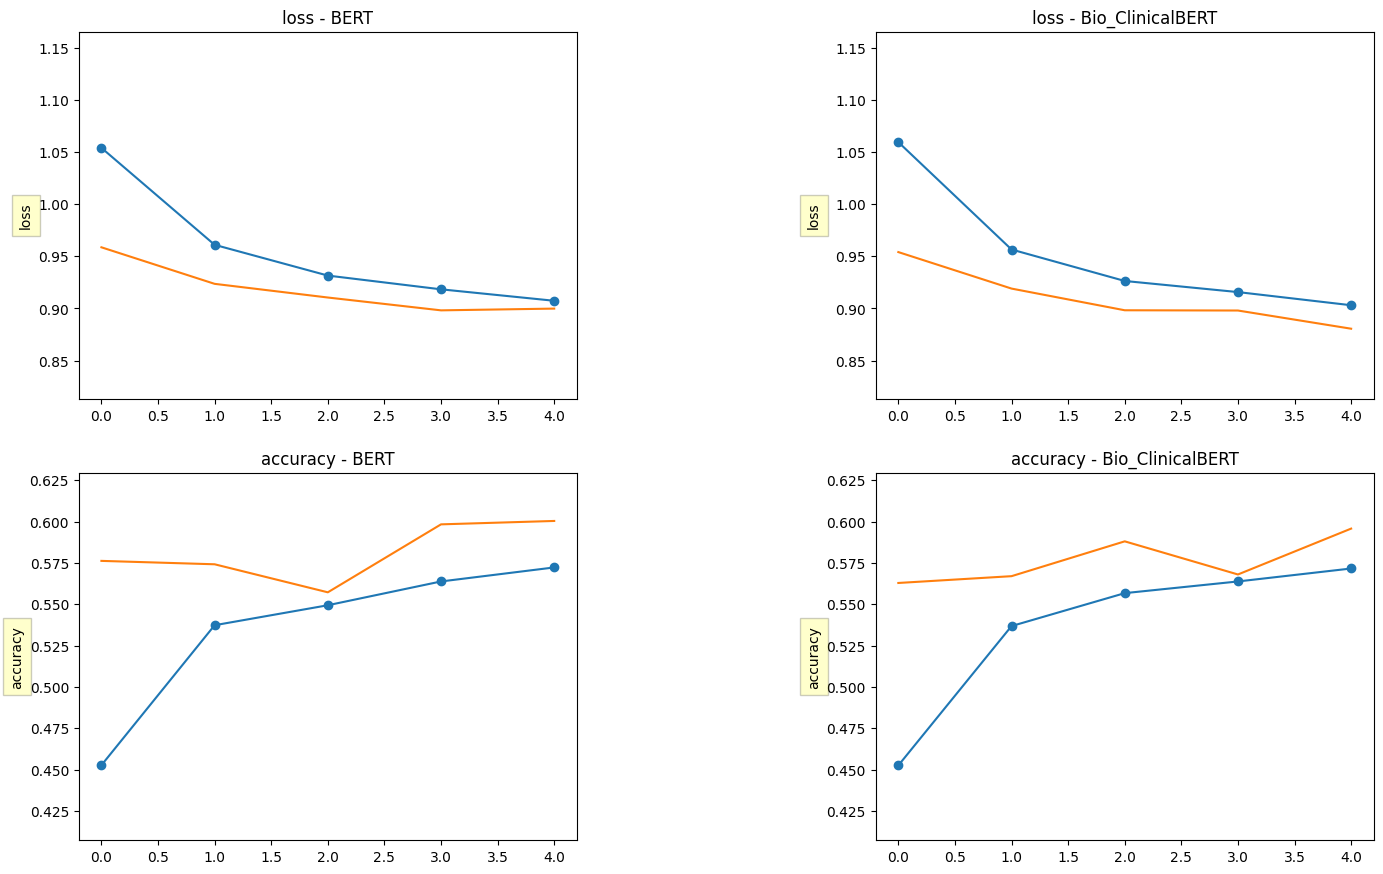

In [ ]:
# model 1 Basic BERT model compared to Bio_Clinical BERT model 2 with fine tuning over 5 epocs, learning rate 0.00005
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs,
          model_history1,
          model_history2,
          model_1_name='BERT',
          model_2_name='Bio_ClinicalBERT')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

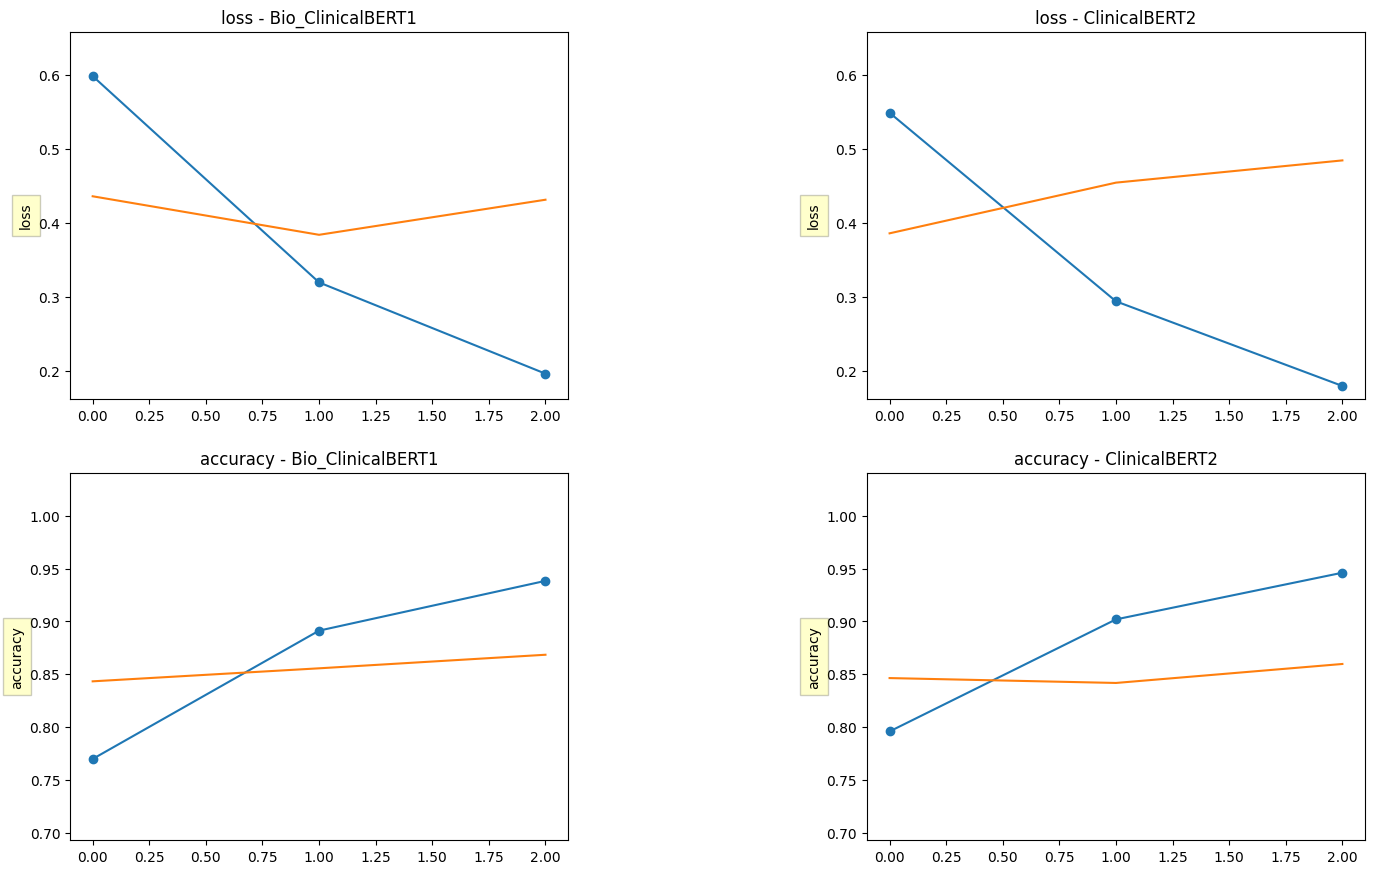

In [ ]:
# model 3a Bio_Clinical BERT model compared to another Clinical BERT model 3b unfreeze pre-trained layers with fine tuning over 3 epocs, learning rate 0.00005
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs,
          model_history3a,
          model_history3b,
          model_1_name='Bio_ClinicalBERT1',
          model_2_name='ClinicalBERT2')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

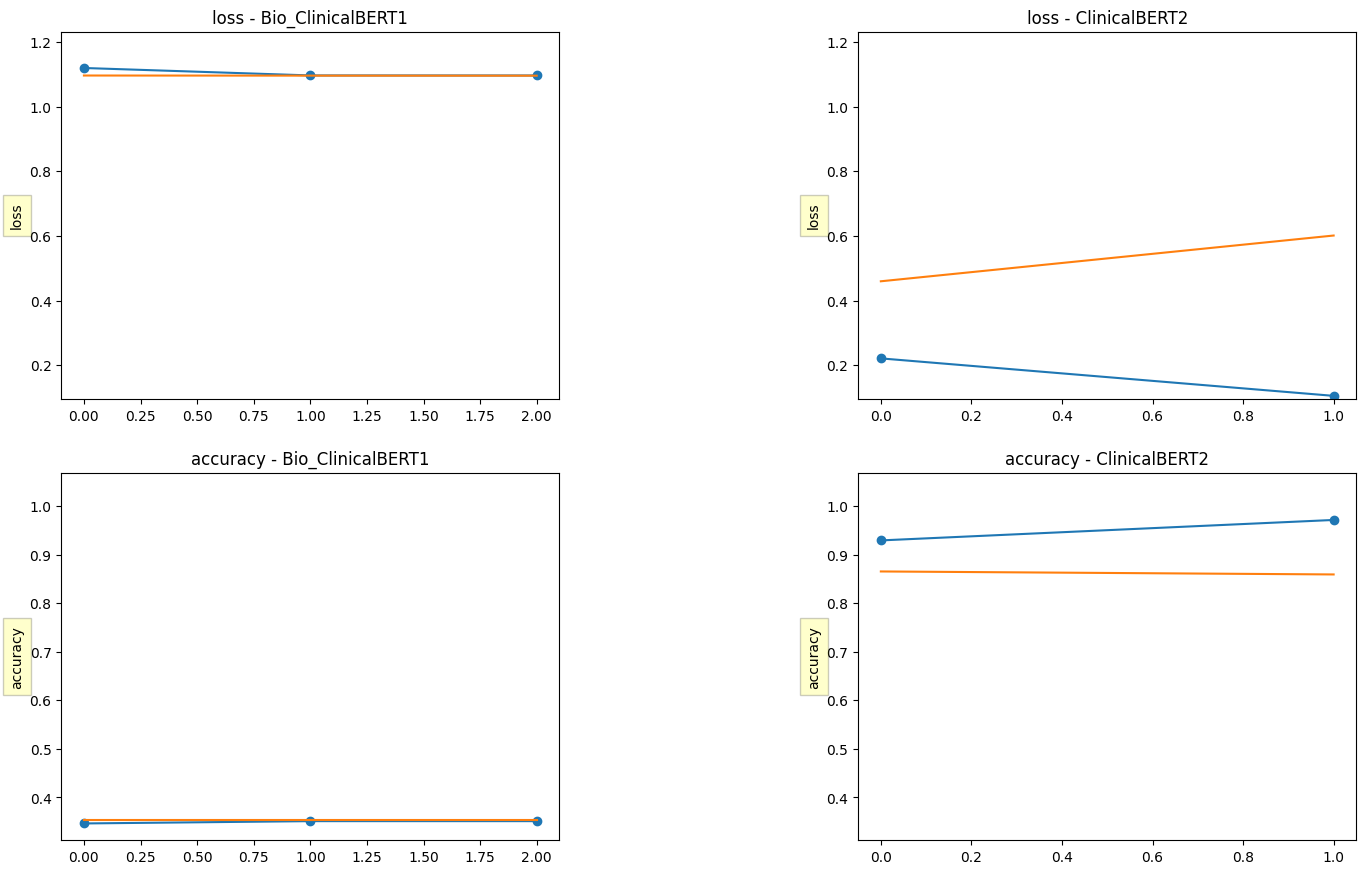

In [ ]:
# model 4a Bio_Clinical BERT model with learning rate 0.0005 compared to Bio_Clinical BERT model 4b unfreeze pre-trained layers with fine tuning over 2 epocs, batch size 20
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs,
          model_history4a,
          model_history4b,
          model_1_name='Bio_ClinicalBERT1',
          model_2_name='ClinicalBERT2')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

##### Note: In this KFold cross validation approach using n = 2 only due to system resource constraints as any more than that is taking more than 2 hours to process or crashing due to RAM memory limitations.

**Using KFold cross validation with Bio Clinical BERT model5**

[Return to Top](#returnToTop)  
<a id = '11. Bio Clinical BERT model using KFold CV'></a>
# 11. Bio Clinical BERT model using KFold CV

In [ ]:
n = 2
seed =45

kf = KFold(n_splits=n, random_state=seed, shuffle=True)

results = []

for train_index, val_index in kf.split(X3_data):
    # splitting Dataframe (dataset not included)
    train_df = X3_data.iloc[train_index]
    val_df = X3_data.iloc[val_index]

    # Defining Model
    model4 = ClassificationModel('bert', 'emilyalsentzer/Bio_ClinicalBERT', args={"overwrite_output_dir": True}, use_cuda=False, num_labels = 3)
    # train the model
    model4.train_model(train_df)
    # validate the model
    result, model_outputs, wrong_predictions = model4.eval_model(val_df, acc=accuracy_score)
    print(result['acc'])
    # append model score
    results.append(result['acc'])


print("results",results)
print(f"Mean-Precision: {sum(results) / len(results)}")

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:612: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/4866 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/609 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/4867 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/609 [00:00<?, ?it/s]

0.8323402506677625


/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:612: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/4867 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/609 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/4866 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/609 [00:00<?, ?it/s]

0.8316892725030827
results [0.8323402506677625, 0.8316892725030827]
Mean-Precision: 0.8320147615854225
